## Use of advanced algorithms
The goal of this notebook is to apply some of the algorithms available in stable-baselines3 and see if the results on slimevolleygym environment are successful.

In [1]:
from os.path import join
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import gym
import slimevolleygym
from slimevolleygym import SurvivalRewardEnv
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.callbacks import EvalCallback
from stable_baselines3 import A2C, PPO, DQN, SAC

plt.style.use('seaborn')

MODELDIR = join('..', 'models')
LOGDIR = join('..', 'logs', 'advanced')
TIMESTEPS = 3e6

We create a wrapper which inherits from gym.ActionWrapper to enable the use of algorithms which require a continuous action space. This way, we do not limit ourselves to test just a few of the algorithms from sb3.

In [2]:
class DiscreteToBoxWrapper(gym.ActionWrapper):
    def __init__(self, env, new_action_set):
        super().__init__(env)
        self.new_action_set = new_action_set
        self.action_space = gym.spaces.Box(low=np.array([0, 1]), high=np.array([1, 5.999]))
        
    def action(self, box_act):
        if box_act[0] < 0.5:
            action = self.new_action_set[0]
        else:
            action = self.new_action_set[int(np.floor(box_act[1]))]
        return action
    
class ReducedDimension(gym.ObservationWrapper):
    def __init__(self, env):
        super().__init__(env)
        self._observation_space = gym.spaces.Box(shape=(8,), low=-2.0, high=2.0)
    def observation(self, obs):
        return obs[0:8]

We define a function which plots the the rewards and the lenghts of each of the episodes, as well as the average of them.

In [3]:
def plot_sb_results(filename, title):
    metrics = pd.read_csv(join(LOGDIR, filename), skiprows=1)
    episode_rew = metrics.loc[:, 'r']
    episode_rew_average = episode_rew.expanding().mean()
    
    fig, ax = plt.subplots(figsize=(15, 6))

    ax.plot(episode_rew, label='Reward per episode')
    ax.plot(episode_rew_average, label='Mean reward overall')
    ax.set_xlabel('Episodes')
    ax.set_ylabel('Reward')
    ax.set_title(title)
    ax.legend(loc='upper left');

We define a function to evaluate an algorithm in an environment given a policy and a number of episodes.

In [4]:
def evaluate_algorithm(env, policy, episodes):
    rewards = np.zeros(episodes)
    lengths = np.zeros(episodes)
    ep = 0
    for i in range(episodes):
        S = env.reset()
        G = 0
        t = 0
        ep += 1
        done = False
        while not done:
            A, _states = policy.predict(S, deterministic=True)
            S, R, done, _ = env.step(A)
            G += R
            t += 1
        rewards[i] = G
        lengths[i] = t
    return rewards, lengths

def save_results(rewards, lengths, file_name):
    training_data = np.vstack((rewards, lengths)).T
    np.savetxt(join(LOGDIR, file_name), training_data, delimiter=',',
               header='eval_rewards,eval_lengths', comments='')

### PPO

#### Use of slimevolley env without wrappers

##### Training

In [ ]:
slime_env = Monitor(env=gym.make('SlimeVolley-v0'),
                    filename=join(LOGDIR, 'ppo3m'))

eval_callback = EvalCallback(slime_env,
                             best_model_save_path=join(MODELDIR, 'PPO'),
                             eval_freq=100_000,
                             n_eval_episodes=100)

ppo_model = PPO('MlpPolicy', slime_env, verbose=0)

ppo_model.learn(TIMESTEPS, callback=eval_callback);

In [ ]:
ppo_model.save(join(MODELDIR, 'PPO', 'PPO_3M'))

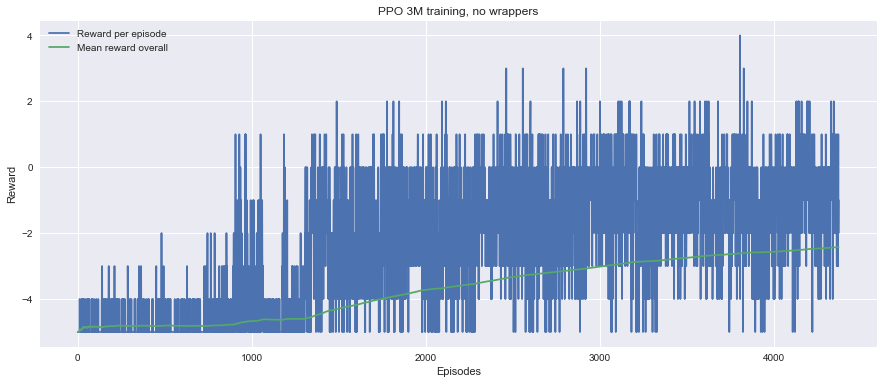

In [5]:
plot_sb_results('ppo3m.monitor.csv', 'PPO 3M training, no wrappers')

##### Evaluation

In [ ]:
slime_env_gym = gym.make('SlimeVolley-v0')

ppo_policy = PPO.load(join(MODELDIR, 'PPO', 'PPO_3M'), env=slime_env_gym)
eval_rew, eval_len = evaluate_algorithm(slime_env_gym, ppo_policy, 1000)

ppo_best_policy = PPO.load(join(MODELDIR, 'PPO', 'best_model'), env=slime_env_gym)
best_eval_rew, best_eval_len = evaluate_algorithm(slime_env_gym, ppo_best_policy, 1000)

In [ ]:
save_results(eval_rew, eval_len, 'ppo3m_eval.csv')
save_results(best_eval_rew, best_eval_len, 'ppo3m_best_eval.csv')

#### Use of slimevolley env + SurvivalRewardEnv, ReducedDimension wrapper

##### Training

In [ ]:
slime_env = Monitor(env=SurvivalRewardEnv(ReducedDimension(gym.make('SlimeVolley-v0'))),
                    filename=join(LOGDIR, 'ppo3m_wra'))

eval_callback = EvalCallback(slime_env,
                             best_model_save_path=join(MODELDIR, 'PPO_WRA'),
                             eval_freq=100_000,
                             n_eval_episodes=100)

ppo_model = PPO('MlpPolicy', slime_env, verbose=0)

ppo_model.learn(TIMESTEPS, callback=eval_callback);

In [ ]:
# Wont be used once the threshold is defined
ppo_model.save(join(MODELDIR, 'PPO_WRA', 'PPO_3M_WRA'))

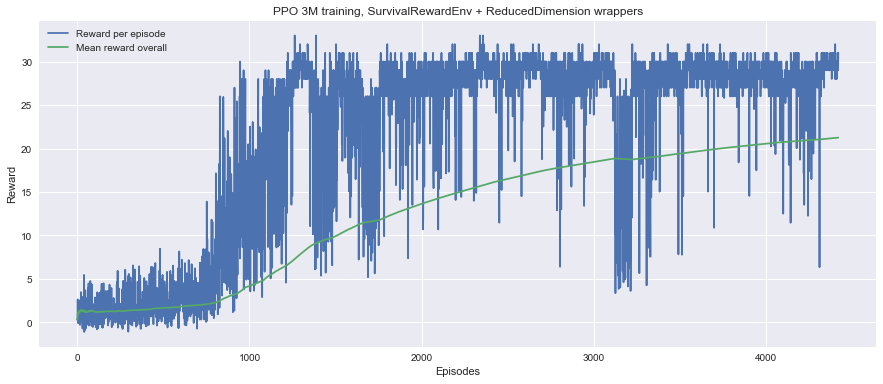

In [6]:
plot_sb_results('ppo3m_wra.monitor.csv', 'PPO 3M training, SurvivalRewardEnv + ReducedDimension wrappers')

##### Evaluation

In [ ]:
slime_env_gym = ReducedDimension(gym.make('SlimeVolley-v0'))

ppo_wra_policy = PPO.load(join(MODELDIR, 'PPO_WRA', 'PPO_3M_WRA'), env=slime_env_gym)
eval_rew, eval_len = evaluate_algorithm(slime_env_gym, ppo_wra_policy, 1000)

ppo_wra_best_policy = PPO.load(join(MODELDIR, 'PPO_WRA', 'PPO_3M_WRA'), env=slime_env_gym)
best_eval_rew, best_eval_len = evaluate_algorithm(slime_env_gym, ppo_wra_best_policy, 1000)

In [ ]:
save_results(eval_rew, eval_len, 'ppo3m_wra_eval.csv')
save_results(best_eval_rew, best_eval_len, 'ppo3m_wra_best_eval.csv')

#### Result comparaison

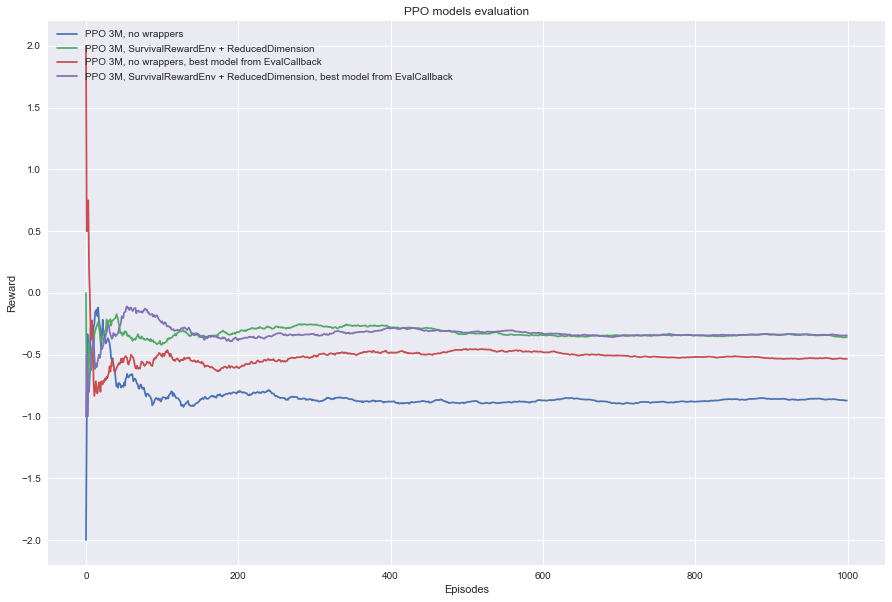

In [9]:
avg_eval_rews = pd.DataFrame({
    "ppo3m": pd.read_csv(join(LOGDIR, 'ppo3m_eval.csv')).loc[:, 'eval_rewards'].expanding().mean(),
    "ppo3m_wra": pd.read_csv(join(LOGDIR, 'ppo3m_wra_eval.csv')).loc[:, 'eval_rewards'].expanding().mean(),
    "ppo3m_best": pd.read_csv(join(LOGDIR, 'ppo3m_best_eval.csv')).loc[:, 'eval_rewards'].expanding().mean(),
    "ppo3m_wra_best": pd.read_csv(join(LOGDIR, 'ppo3m_wra_best_eval.csv')).loc[:, 'eval_rewards'].expanding().mean(),
})

fig, ax = plt.subplots(figsize=(15, 10))

ax.plot(avg_eval_rews.iloc[:, 0], label='PPO 3M, no wrappers')
ax.plot(avg_eval_rews.iloc[:, 1], label='PPO 3M, SurvivalRewardEnv + ReducedDimension')
ax.plot(avg_eval_rews.iloc[:, 2], label='PPO 3M, no wrappers, best model from EvalCallback')
ax.plot(avg_eval_rews.iloc[:, 3], label='PPO 3M, SurvivalRewardEnv + ReducedDimension, best model from EvalCallback')
ax.set_xlabel('Episodes')
ax.set_ylabel('Reward')
ax.set_title('PPO models evaluation')
ax.legend(loc='upper left');

### A2C

##### Training

In [ ]:
slime_env = Monitor(env=SurvivalRewardEnv(ReducedDimension(gym.make('SlimeVolley-v0'))),
                    filename=join(LOGDIR, 'a2c3m'))

a2c_model = A2C('MlpPolicy', slime_env, verbose=1)

a2c_model.learn(TIMESTEPS);

In [ ]:
a2c_model.save(join(MODELDIR, 'A2C', 'A2C_3M'))

In [ ]:
plot_sb_results('a2c3m.monitor.csv')

### DQN

##### Training

In [ ]:
slime_env = Monitor(env=SurvivalRewardEnv(ReducedDimension(gym.make('SlimeVolley-v0'))),
                    filename=join(LOGDIR, 'dqn3m'))

dqn_model = DQN('MlpPolicy', slime_env, verbose=1)

dqn_model.learn(TIMESTEPS);

In [ ]:
dqn_model.save(join(MODELDIR, 'DQN', 'DQN_3M'))

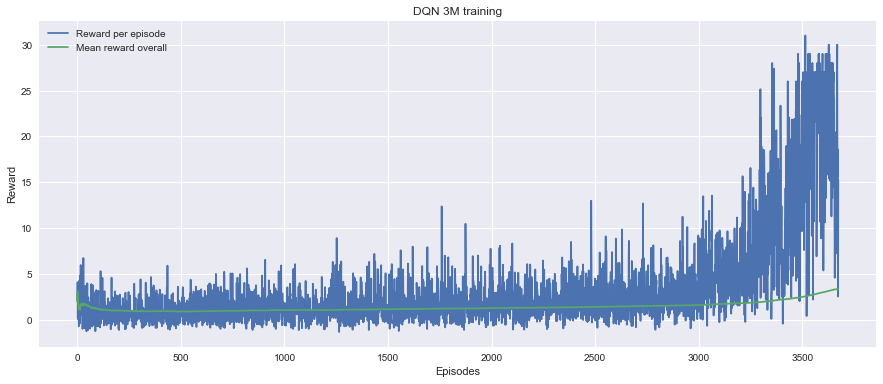

In [12]:
plot_sb_results('dqn3m.monitor.csv', 'DQN 3M training')

#### Evaluation

In [ ]:
slime_env_gym = ReducedDimension(gym.make('SlimeVolley-v0'))

dqn_policy = DQN.load(join(MODELDIR, 'DQN', 'DQN_3M'), env=slime_env_gym)
eval_rew, eval_len = evaluate_algorithm(slime_env_gym, dqn_policy, 1000)

In [ ]:
save_results(eval_rew, eval_len, 'dqn3m_eval.csv')

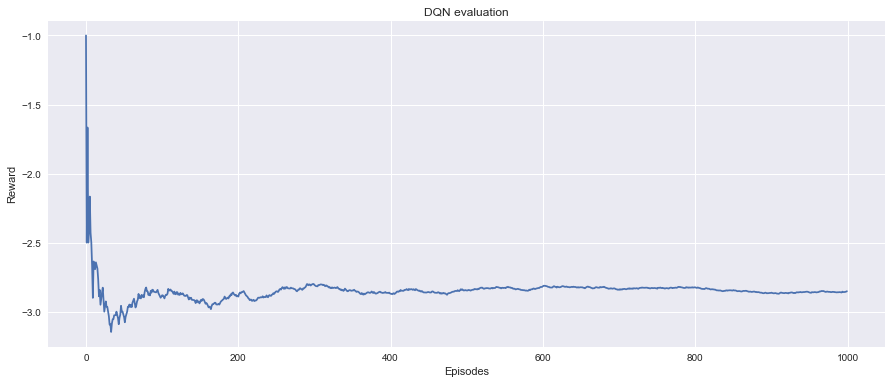

In [20]:
dqn_eval = pd.read_csv(join(LOGDIR, 'dqn3m_eval.csv')).loc[:, 'eval_rewards'].expanding().mean()
fig, ax = plt.subplots(figsize=(15, 6))
ax.plot(dqn_eval)
ax.set_xlabel('Episodes')
ax.set_ylabel('Reward')
ax.set_title('DQN evaluation');

### SAC

##### Training

In [ ]:
action_table = [[0, 0, 0], # NOOP
                [1, 0, 0], # LEFT (forward)
                [1, 0, 1], # UPLEFT (forward jump)
                [0, 0, 1], # UP (jump)
                [0, 1, 1], # UPRIGHT (backward jump)
                [0, 1, 0]] # RIGHT (backward)


slime_env = Monitor(env=SurvivalRewardEnv(DiscreteToBoxWrapper(ReducedDimension(gym.make('SlimeVolley-v0')), action_table)),
                    filename=join(LOGDIR, 'sac1m'))

model = SAC('MlpPolicy', slime_env, verbose=1)

model.learn(1_000_000);

In [ ]:
model.save(join(MODELDIR, 'SAC', 'SAC_1M'))

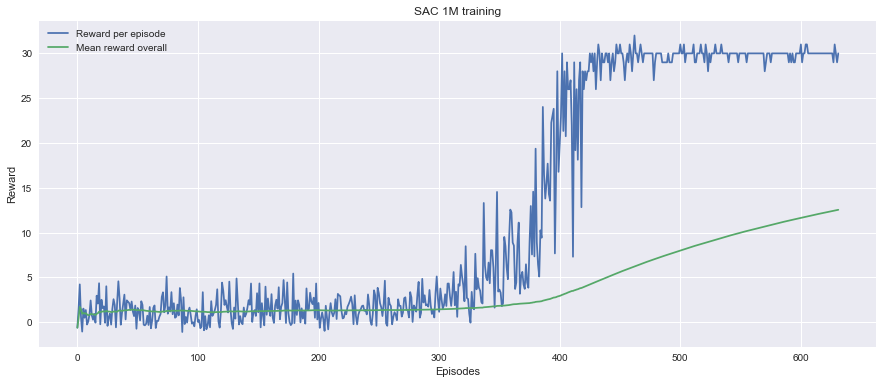

In [15]:
plot_sb_results('sac1m.monitor.csv', 'SAC 1M training')

##### Evaluation

In [ ]:
slime_env_gym = DiscreteToBoxWrapper(ReducedDimension(gym.make('SlimeVolley-v0')), action_table)

sac_policy = SAC.load(join(MODELDIR, 'SAC', 'SAC_1M'), env=slime_env_gym)
eval_rew, eval_len = evaluate_algorithm(slime_env_gym, sac_policy, 1000)

In [ ]:
save_results(eval_rew, eval_len, 'sac1m_eval.csv')

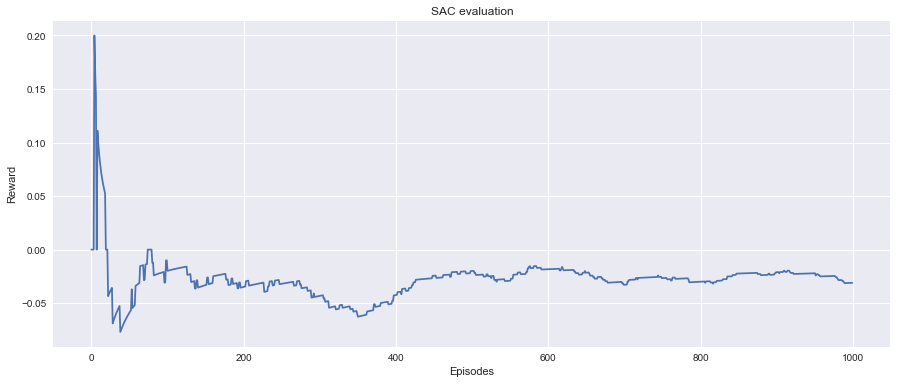

In [19]:
sac_eval = pd.read_csv(join(LOGDIR, 'sac1m_eval.csv')).loc[:, 'eval_rewards'].expanding().mean()
fig, ax = plt.subplots(figsize=(15, 6))
ax.plot(sac_eval)
ax.set_xlabel('Episodes')
ax.set_ylabel('Reward')
ax.set_title('SAC evaluation');